In [1]:
import telepot
import time
import json
import functools
import tweepy as tw
from telepot.loop import MessageLoop
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datetime import date
from datetime import datetime
from nltk import sent_tokenize, TweetTokenizer, WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from gensim.models.tfidfmodel import TfidfModel
import gensim.downloader as down
from gensim.corpora import Dictionary
import spacy
import seaborn as sns
import pandas as pd
import re
import unicodedata

In [2]:
class Bot:
    def __init__(self,id):
        print("Preparing bot...")
        with open('bot.json','r') as file:
            bot_api = file.read()
            json_object = json.loads(bot_api)
            self.bot = telepot.Bot(json_object['api'])
            self.nlp = spacy.load('en')
        print("Done!")
        
    def strip_accents(self,text):
        try:
            text = unicode(text, 'utf-8')
        except NameError: # unicode is a default on python 3 
            pass

        text = unicodedata.normalize('NFD', text)\
               .encode('ascii', 'ignore')\
               .decode("utf-8")

        return str(text)
        
    def find_entities(self,text):
        entities = []
        doc = self.nlp(text)
        for ent in doc.ents:
            entities.append([ent.ents[0], ent.ents[0].label_])
        return entities
    
    def entity_type(self,ents,label):
        return([str(ent[0]) for ent in ents if ent[1] == label])
    
    def prepare_query(self,ents):
        string = '('
        size = len(ents)
        i = 0
        list_of_words = []
        for ent in ents:
            words = ent.split(' ')
            for word in words:
                list_of_words.append(word)
        while(i < size):
            string += list_of_words[i]
            if(i != size - 1):
                string += ' AND ' #' OR '
            else:
                string += ')'
            i += 1
        return string
    
    def cleaning_tweets(self,tweets):
        list_of_words = list()
        lemma = WordNetLemmatizer()
        tweet_token = TweetTokenizer(strip_handles=True)
        stemmer = PorterStemmer()
        for tweet in tweets:
            words = tweet_token.tokenize(tweet)
            words = [w.lower() for w in words]
            words = [self.strip_accents(w) for w in words if w not in stopwords.words("english")
                     and w.isalpha()
                     and w != 'rt'
                     and w.find("http") == -1]
            words = [lemma.lemmatize(w) for w in words]
            list_of_words += words
        return list_of_words
    
    def process_sentences(self,tweets):
        list_of_sentences = list()
        lemma = WordNetLemmatizer()
        tweet_token = TweetTokenizer(strip_handles=True)
        stemmer = PorterStemmer()
        for tweet in tweets:
            words = tweet_token.tokenize(tweet)
            words = [w.lower() for w in words]
            words = [self.strip_accents(w) for w in words if w not in stopwords.words("english")
                     and w.isalpha()
                     and w != 'rt']
            words = [lemma.lemmatize(w) for w in words]
            list_of_sentences.append(words)
        return list_of_sentences
    
    def create_dataframe_figure(self,df):
        sns.set(style="whitegrid")
        tips = sns.load_dataset("tips")
        ax = sns.barplot(x="Count", y="Word", data=df)
        fig = ax.get_figure()
        fig.savefig('bar.png',dpi=400,bbox_inches='tight')
        plt.show()
        
    def create_wordcloud(self,strings):
        wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(strings)
        plt.figure(figsize = (10, 10), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.savefig('cloud.png',dpi=400)
        plt.show()
        
    def top_words(self,corpus,number=10):
        corpus.sort(key=lambda x: x[1],reverse=True)
        return corpus[:number]
    
    def listen_msg(self,msg):
        try:
            print(msg['text'])
            self.bot.sendMessage(msg['chat']['id'],f'I received: {msg["text"]}')
            self.bot.sendMessage(msg['chat']['id'],'Looking for it...')
            entities = self.find_entities(msg['text'])
            if(entities == []):
                self.bot.sendMessage(msg['chat']['id'],'Please, send another question.')
                return 1

            person = self.entity_type(entities,'PERSON')
            organization = self.entity_type(entities,'ORG')
            location = self.entity_type(entities,'GPE')

            entities = person + organization + location

            string_entities = functools.reduce(lambda x,y: x+'\n'+y,entities)
            self.bot.sendMessage(msg['chat']['id'],f'Entities found:\n{string_entities}')

            self.bot.sendMessage(msg['chat']['id'],'Searching on Twitter...')
            query = self.prepare_query(entities)
            tweets = tw.Cursor(self.api.search,
                  q=query
                      ).items(100)

            self.bot.sendMessage(msg['chat']['id'],'Processing text from tweets (it may take some time)...')

            raw_tweet_text = [x.text for x in tweets]

            list_of_words = self.cleaning_tweets(raw_tweet_text)

            dataframe_count = pd.DataFrame(Counter(list_of_words) \
                             .most_common(20),columns=['Word','Count'])

            self.bot.sendMessage(msg['chat']['id'],'Creating a list with 20 most used words...')
            self.create_dataframe_figure(dataframe_count)
            self.bot.sendPhoto(msg['chat']['id'],photo=open('bar.png','rb'))
            self.bot.sendMessage(msg['chat']['id'],'Creating a Word Cloud...')
            strings = ''
            for s in list_of_words:
                strings += s+' '
            self.create_wordcloud(strings)
            self.bot.sendPhoto(msg['chat']['id'],photo=open('cloud.png','rb'))

            self.bot.sendMessage(msg['chat']['id'],'Processing most important words...')
            list_of_sentences = self.process_sentences(raw_tweet_text)
            dct = Dictionary(list_of_sentences)
            corpus = [dct.doc2bow(line) for line in list_of_sentences]
            tfidf = TfidfModel(corpus)
            number_per_corpus = 10
            most_important = [self.top_words(tfidf[c],number_per_corpus) for c in corpus]
            most_important_names = list()
            for m in most_important:
                most_important_names += [dct[name[0]] for name in m]

            self.bot.sendMessage(msg['chat']['id'],'Creating a list with 10 most important words...')
            dataframe_most_important = pd.DataFrame(Counter(most_important_names) \
                             .most_common(10),columns=['Word','Count'])
            self.create_dataframe_figure(dataframe_most_important)
            self.bot.sendPhoto(msg['chat']['id'],photo=open('bar.png','rb'))

            self.bot.sendMessage(msg['chat']['id'],'Creating a Word Cloud with the most important words...')
            strings = ''
            for s in most_important_names:
                strings += s+' '
            self.create_wordcloud(strings)
            self.bot.sendPhoto(msg['chat']['id'],photo=open('cloud.png','rb'))

            self.bot.sendMessage(msg['chat']['id'],'Searching for entities in the tweets...')
            sentence_list = list()
            for tweet in raw_tweet_text:
                sentence_list += sent_tokenize(self.strip_accents(tweet))
            entities_tweets = []
            for sent in sentence_list:
                doc = self.nlp(sent)
                for i in doc.ents:
                    if(str(i.ents[0]).find('http') == -1):
                        entities_tweets.append([i.ents[0], i.ents[0].label_])

            self.bot.sendMessage(msg['chat']['id'],'Creating a list with top 10 people mentioned in the tweets...')
            person = self.entity_type(entities_tweets,'PERSON')
            dataframe_person = pd.DataFrame(Counter(person) \
                         .most_common(20),columns=['Word','Count'])
            self.create_dataframe_figure(dataframe_person)
            self.bot.sendPhoto(msg['chat']['id'],photo=open('bar.png','rb'))

            self.bot.sendMessage(msg['chat']['id'],'Creating a list with top 10 organizations mentioned in the tweets...')
            org = self.entity_type(entities_tweets,'ORG')
            dataframe_org = pd.DataFrame(Counter(org) \
                         .most_common(20),columns=['Word','Count'])
            self.create_dataframe_figure(dataframe_org)
            self.bot.sendPhoto(msg['chat']['id'],photo=open('bar.png','rb'))



            self.bot.sendMessage(msg['chat']['id'],'Finished!')
        except Exception as e:
            print(e)
            self.bot.sendMessage(msg['chat']['id'],'Sorry, we had an error! Please, try again')
        
    def open_twitter(self):
        with open('creds.json','r') as file:
            credentials = file.read()
            json_object = json.loads(credentials)
            auth = tw.OAuthHandler(json_object['consumer_key'], 
                                   json_object['consumer_secret'])
            auth.set_access_token(json_object['access_token'], 
                                  json_object['access_token_secret'])
            self.api = tw.API(auth, wait_on_rate_limit=True)
        
    def start_bot(self):
        self.open_twitter()
        MessageLoop(self.bot,self.listen_msg).run_as_thread()
        

In [3]:
bot = Bot("1223523475:AAGfC1PmvmQAxRIkzCLxI7dxwB42nM4m4w0")

Preparing bot...
Done!


I want to know about Jeff Bezos and Bill Gates in California


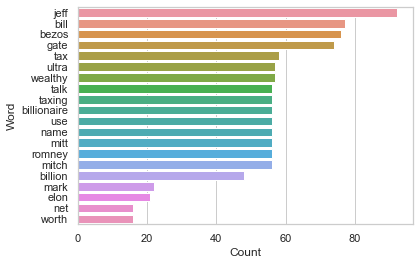

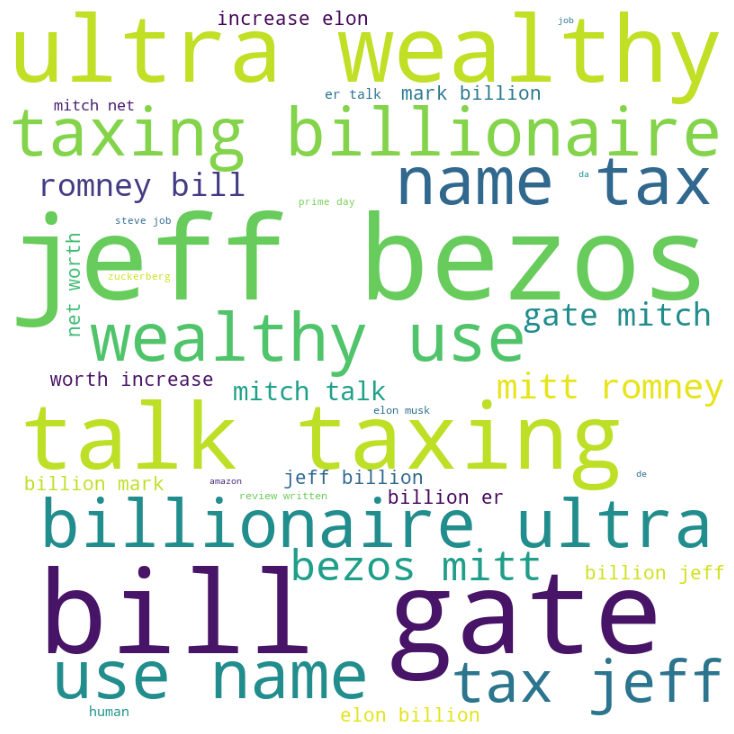

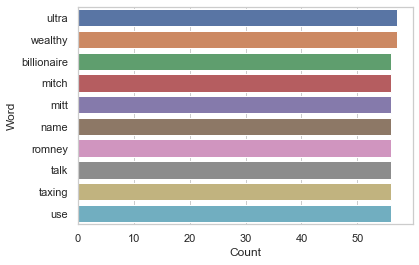

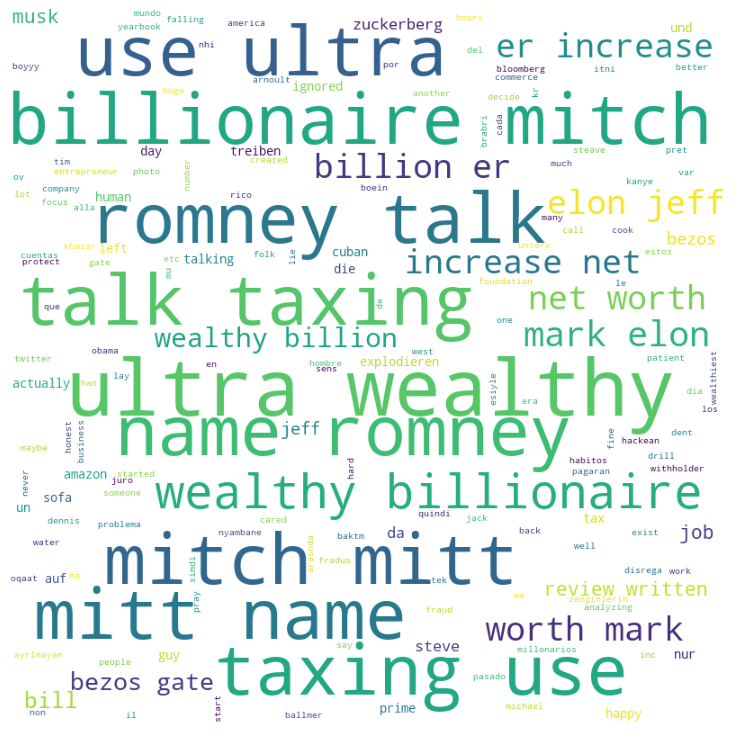

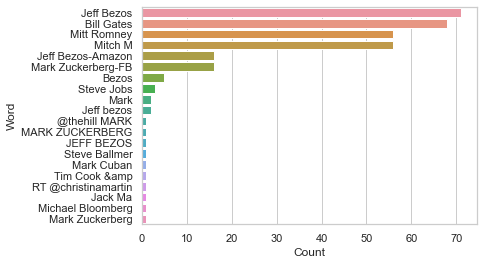

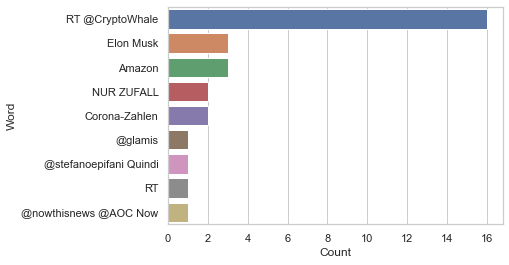

In [4]:
bot.start_bot()